<a href="https://colab.research.google.com/github/issa-project/issa-pipeline/blob/main/notebooks/issa-descriptor-analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sampling of Thematic Descriptors in ISSA dataset

**Comparing human and automated indexation of the document text**  

Use case: Agritrop ISSA

Endpoint: https://data-issa.cirad.fr/sparql

In [49]:
import os
try:
    isColab = os.environ['GCE_METADATA_TIMEOUT']
    if isColab:
        !pip install SPARQLWrapper
except:
    pass

In [3]:
import pandas as pd
import numpy as np
import json
import copy
import math

from SPARQLWrapper import SPARQLWrapper, JSON, POST

import matplotlib.pyplot as plt

from IPython.display import display, display_html

In [44]:
import re
def sparql_service_to_dataframe(service, query, remove_comments=False):
    """
    Helper function to convert SPARQL results into a Pandas DataFrame.
    
    Credit to Ted Lawless https://lawlesst.github.io/notebook/sparql-dataframe.html
    """
    sparql = SPARQLWrapper(service)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    sparql.setMethod(POST)
    
    # Remove comments to make a request shorter
    if (remove_comments):
        query = re.sub(r'(?m)^ *#.*\n?', '', query)

    result = sparql.query()

    processed_results = json.load(result.response)
    cols = processed_results['head']['vars']

    out = []
    for row in processed_results['results']['bindings']:
        item = []
        for c in cols:
            item.append(row.get(c, {}).get('value'))
        out.append(item)
    
    return pd.DataFrame(out, columns=cols) 

In [6]:
issa_instances = {'agritrop': {'endpoint' : 'https://data-issa.cirad.fr/sparql',
                               'namespace' : 'http://data-issa.cirad.fr/',
                               'name': 'issa-agritrop',
                               'graph': 'http://data-issa.cirad.fr/graph/dataset'
                              },
                 }

instance='agritrop'

issa_agritrop_endpoint = issa_instances[instance]['endpoint']

## Dataset info

In [9]:
ns= issa_instances[instance]['namespace']
ds= issa_instances[instance]['name']

dataset_info_query = f'''
PREFIX rdf:  <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX void: <http://rdfs.org/ns/void#> 
PREFIX dct:    <http://purl.org/dc/terms/>
PREFIX prov: <http://www.w3.org/ns/prov#>

SELECT * 
FROM <{ns}graph/dataset>
WHERE {{
  VALUES (?dataset) {{ (<{ns}{ds}>) }}
  
  ?datatest dct:title ?dataset_name;
                     dct:description ?dataset_description;
                     void:triples ?triple_count;
                     owl:versionInfo ?version;
                     dct:issued ?initial_date;
                     prov:generatedAtTime ?generated_date.
  
  OPTIONAL{{ ?dataset dct:modified ?updated_date. }}
}} 
'''
#print(dataset_info_query)

In [45]:
pd.options.display.max_colwidth = 80
dataset_info = sparql_service_to_dataframe(issa_agritrop_endpoint, dataset_info_query)
dataset_info.transpose()

,0
dataset,http://data-issa.cirad.fr/issa-agritrop
datatest,http://data-issa.cirad.fr/issa-agritrop
dataset_name,ISSA Agritrop dataset
dataset_description,This RDF dataset was produced by processing articles from Agritrop - the ope...
triple_count,131494758
version,2.0.20231002
initial_date,2022-04-29
generated_date,2023-10-19
updated_date,2023-10-19


## Sample articles and their descriptors

In [29]:
#latest_training_paper_id = 600364
latest_training_paper_id = 575483 #(2.0) 600364 # (1.2) 575483 (2.0)

sample_size = 60

seed = 42

In [30]:
ns= issa_instances[instance]['namespace']
ds= issa_instances[instance]['name']

articles_ids_query = f'''
PREFIX dce: <http://purl.org/dc/elements/1.1/>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX prov: <http://www.w3.org/ns/prov#>
prefix bibo:   <http://purl.org/ontology/bibo/>
PREFIX dct:    <http://purl.org/dc/terms/>
PREFIX fabio:  <http://purl.org/spar/fabio/>
PREFIX oa:     <http://www.w3.org/ns/oa#>
PREFIX rdfs:   <http://www.w3.org/2000/01/rdf-schema#>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX skosxl: <http://www.w3.org/2008/05/skos-xl#>
PREFIX frbr:   <http://purl.org/vocab/frbr/core#>
PREFIX issa:    <http://data-issa.cirad.fr/> 

PREFIX issa:   <{ns}>
PREFIX issapr: <{ns}property/>

SELECT  distinct ?paperURI ?paperID ?lang
        
FROM <{ns}graph/documents>
FROM <{ns}graph/thematic-descriptors>
FROM <{ns}graph/annif-descriptors>
FROM <{ns}graph/documents/text>
FROM <http://agrovoc.fao.org/graph>

WHERE {{
        ?paperURI dct:identifier ?paperID;
                     dce:language ?lang;
                     ^frbr:partOf ?textURI.
                     
         FILTER ( EXISTS {{ ?paperURI a bibo:AcademicArticle }} )
         FILTER ( xsd:integer(?paperID) > {latest_training_paper_id} )
         FILTER ( EXISTS {{  ?descrH oa:hasTarget ?paperURI;
                             prov:wasAttributedTo issa:Documentalist. }} )
         FILTER ( EXISTS {{  ?descrM oa:hasTarget ?paperURI;
                             prov:wasAttributedTo issa:AnnifSubjectIndexer. }} )
         
         FILTER (EXISTS {{?textURI a issa:DocumentBody}} )
         FILTER (not EXISTS {{?textURI rdf:value ?text}} )

}}
ORDER BY ?paperID
'''

In [31]:
thesis_ids_query = f'''
PREFIX dce: <http://purl.org/dc/elements/1.1/>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX prov: <http://www.w3.org/ns/prov#>
prefix bibo:   <http://purl.org/ontology/bibo/>
PREFIX dct:    <http://purl.org/dc/terms/>
PREFIX fabio:  <http://purl.org/spar/fabio/>
PREFIX oa:     <http://www.w3.org/ns/oa#>
PREFIX rdfs:   <http://www.w3.org/2000/01/rdf-schema#>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX skosxl: <http://www.w3.org/2008/05/skos-xl#>
PREFIX frbr:   <http://purl.org/vocab/frbr/core#>

PREFIX issa:   <{ns}>
PREFIX issapr: <{ns}property/>

SELECT  distinct ?paperURI ?paperID ?lang
        
FROM <{ns}graph/documents>
FROM <{ns}graph/thematic-descriptors>
FROM <{ns}graph/annif-descriptors>
FROM <{ns}graph/documents/text>
FROM <http://agrovoc.fao.org/graph>

WHERE {{
        ?paperURI dct:identifier ?paperID;
                     dce:language ?lang.
                     
         FILTER ( EXISTS {{ ?paperURI a fabio:Thesis }} )
         FILTER ( xsd:integer(?paperID) > {latest_training_paper_id} )
         FILTER ( EXISTS {{  ?descrH oa:hasTarget ?paperURI;
                             prov:wasAttributedTo issa:Documentalist. }} )
         FILTER ( EXISTS {{  ?descrM oa:hasTarget ?paperURI;
                             prov:wasAttributedTo issa:AnnifSubjectIndexer. }} )

}}
ORDER BY ?paperID
'''

In [32]:
df = sparql_service_to_dataframe(issa_agritrop_endpoint, 
                                 articles_ids_query)
df.shape

(93, 3)

In [33]:
print('en', df.loc[df.lang=='eng'].shape)
print('fr', df.loc[df.lang=='fre'].shape)

en (64, 3)
fr (29, 3)


In [35]:
langs = { 'en': 'eng', 
          'fr' :'fre'}

random_paper_ids = {}

sample_size_en = min( df.loc[df.lang=='eng'].shape[0], sample_size//2)
random_paper_ids['en'] = df.loc[df.lang=='eng'].sample(n=sample_size_en, random_state= 42)

sample_size_fr = min( df.loc[df.lang=='fre'].shape[0], sample_size//2)
random_paper_ids['fr'] = df.loc[df.lang=='fre'].sample(n=sample_size_fr, random_state= 42)

random_paper_ids['both'] = pd.concat(random_paper_ids.values())

In [36]:
langs = { 'en': 'eng', 
          'fr' :'fre'}

random_paper_ids = {}

random_paper_ids['en'] = df.loc[df.lang=='eng']
random_paper_ids['fr'] = df.loc[df.lang=='fre']
random_paper_ids['both'] = pd.concat(random_paper_ids.values())

In [37]:
random_paper_ids['both'].sort_values(by='paperID').head()

,paperURI,paperID,lang
0,http://data-issa.cirad.fr/document/576134,576134,eng
1,http://data-issa.cirad.fr/document/576338,576338,eng
2,http://data-issa.cirad.fr/document/577439,577439,eng
3,http://data-issa.cirad.fr/document/577539,577539,fre
4,http://data-issa.cirad.fr/document/577700,577700,eng


In [40]:
values = ' '.join(['(<%s>)' % x for x in random_paper_ids['both'].paperURI])
max_rank = 15
min_conf = 0.1

paper_descriptors_query_template = f'''
PREFIX schema: <http://schema.org/>
PREFIX dce: <http://purl.org/dc/elements/1.1/>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX prov: <http://www.w3.org/ns/prov#>
prefix bibo:   <http://purl.org/ontology/bibo/>
PREFIX dct:    <http://purl.org/dc/terms/>
PREFIX fabio:  <http://purl.org/spar/fabio/>
PREFIX oa:     <http://www.w3.org/ns/oa#>
PREFIX rdfs:   <http://www.w3.org/2000/01/rdf-schema#>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX skosxl: <http://www.w3.org/2008/05/skos-xl#>

PREFIX issa:   <{ns}>
PREFIX issapr: <{ns}property/>

SELECT  distinct ?lang ?paperURI ?agritrop_url ?paperID 
                 ?descrUri ?descrLabelEN ?descrLabelFR 
                 ?rankHuman ?rankAnnif ?confAnnif


FROM <{ns}graph/documents>
FROM <{ns}graph/thematic-descriptors>
FROM <{ns}graph/annif-descriptors>
FROM <http://agrovoc.fao.org/graph>

WHERE {{
    
  VALUES (?paperURI) {{ {values} }}
  
    ?paperURI dct:identifier ?paperID;
           dce:language ?lang;
           schema:url ?agritrop_url.
    
    {{
        ?descrHuman a issa:ThematicDescriptorAnnotation;
                    oa:hasBody ?descrUri;
                    oa:hasTarget ?paperURI;
                    issapr:rank  ?rankHuman;
                    prov:wasAttributedTo issa:Documentalist.  

        optional {{
          ?descrAnnif a issa:ThematicDescriptorAnnotation;
                      oa:hasBody ?descrUri;
                      oa:hasTarget ?paperURI;
                      issapr:rank  ?rankAnnif;
                      issapr:confidence ?confAnnif;
                      prov:wasAttributedTo issa:AnnifSubjectIndexer. }}
      }}
      UNION
      {{
        ?descrAnnif a issa:ThematicDescriptorAnnotation;
                    oa:hasBody?descrUri;
                    oa:hasTarget ?paperURI;
                    issapr:rank  ?rankAnnif;
                    issapr:confidence ?confAnnif;
                    prov:wasAttributedTo issa:AnnifSubjectIndexer.

        optional {{
          ?descrHuman a issa:ThematicDescriptorAnnotation;
                      oa:hasBody ?descrUri;
                      oa:hasTarget ?paperURI;
                      issapr:rank  ?rankHuman;
                      prov:wasAttributedTo issa:Documentalist  }}
      }}
      
      FILTER (COALESCE(?rankAnnif , 0) < {max_rank}  )  
      FILTER (COALESCE(?confAnnif, 1.0) > {min_conf} )  

      OPTIONAL {{# Find labels
         ?descrUri skosxl:prefLabel/skosxl:literalForm ?descrLabelEN.
          FILTER langMatches(lang(?descrLabelEN), "en") }}
  
      OPTIONAL {{# Find labels
         ?descrUri skosxl:prefLabel/skosxl:literalForm ?descrLabelFR.
          FILTER langMatches(lang(?descrLabelFR), "fr") }}
}}
ORDER BY ?lang ?paperURI ?rankHuman ?rankAnnif
'''

In [46]:
df = sparql_service_to_dataframe(issa_agritrop_endpoint, 
                                 paper_descriptors_query_template )  
df.shape

(1314, 10)

In [47]:
pd.options.display.float_format = '{:,.2f}'.format
#pd.options.display.max_colwidth = None

df= df.astype({'paperID': 'int',
                'rankHuman': 'float',
                'rankAnnif': 'float',
                'confAnnif': 'float'})

df = df.sort_values(by=['lang', 'paperURI', 'rankHuman', 'rankAnnif' ])\
  #.head(20)

In [48]:
df.head()

,lang,paperURI,agritrop_url,paperID,descrUri,descrLabelEN,descrLabelFR,rankHuman,rankAnnif,confAnnif
11,eng,http://data-issa.cirad.fr/document/576134,http://agritrop.cirad.fr/576134/,576134,http://aims.fao.org/aos/agrovoc/c_2018,cultivation,pratique culturale,1.00,NaN,NaN
12,eng,http://data-issa.cirad.fr/document/576134,http://agritrop.cirad.fr/576134/,576134,http://aims.fao.org/aos/agrovoc/c_1374567058134,climate change adaptation,adaptation aux changements climatiques,2.00,2.00,0.48
13,eng,http://data-issa.cirad.fr/document/576134,http://agritrop.cirad.fr/576134/,576134,http://aims.fao.org/aos/agrovoc/c_7113,small farms,petite exploitation agricole,3.00,NaN,NaN
14,eng,http://data-issa.cirad.fr/document/576134,http://agritrop.cirad.fr/576134/,576134,http://aims.fao.org/aos/agrovoc/c_1666,climate change,changement climatique,4.00,1.00,0.67
15,eng,http://data-issa.cirad.fr/document/576134,http://agritrop.cirad.fr/576134/,576134,http://aims.fao.org/aos/agrovoc/c_2228,development policies,politique de développement,5.00,11.00,0.18


In [54]:
df.to_csv('sample of indexed articles.no body text.2.0.csv' , encoding='utf-8',
          index=False, float_format='%.2f')

Save data frame in the format requested by Anne

In [55]:
df_adapted = copy.deepcopy(df)
df_adapted.insert(2, 'Visualisation enrichie', df_adapted.paperURI.apply(lambda x: 'http://erebe-vm3.i3s.unice.fr/visu/?uri=%s' % x) )

df_adapted['Manual'] = df_adapted.rankHuman.apply(lambda x: '' if math.isnan(x) else 'x')
df_adapted['Annif']  = df_adapted.rankAnnif.apply(lambda x: '' if math.isnan(x) else 'x')


df_adapted.drop(columns=['paperURI', 'rankHuman', 'rankAnnif', 'confAnnif'], inplace= True)

df_adapted.head()

,lang,Visualisation enrichie,agritrop_url,paperID,descrUri,descrLabelEN,descrLabelFR,Manual,Annif
11,eng,http://erebe-vm3.i3s.unice.fr/visu/?uri=http://data-issa.cirad.fr/document/5...,http://agritrop.cirad.fr/576134/,576134,http://aims.fao.org/aos/agrovoc/c_2018,cultivation,pratique culturale,x,
12,eng,http://erebe-vm3.i3s.unice.fr/visu/?uri=http://data-issa.cirad.fr/document/5...,http://agritrop.cirad.fr/576134/,576134,http://aims.fao.org/aos/agrovoc/c_1374567058134,climate change adaptation,adaptation aux changements climatiques,x,x
13,eng,http://erebe-vm3.i3s.unice.fr/visu/?uri=http://data-issa.cirad.fr/document/5...,http://agritrop.cirad.fr/576134/,576134,http://aims.fao.org/aos/agrovoc/c_7113,small farms,petite exploitation agricole,x,
14,eng,http://erebe-vm3.i3s.unice.fr/visu/?uri=http://data-issa.cirad.fr/document/5...,http://agritrop.cirad.fr/576134/,576134,http://aims.fao.org/aos/agrovoc/c_1666,climate change,changement climatique,x,x
15,eng,http://erebe-vm3.i3s.unice.fr/visu/?uri=http://data-issa.cirad.fr/document/5...,http://agritrop.cirad.fr/576134/,576134,http://aims.fao.org/aos/agrovoc/c_2228,development policies,politique de développement,x,x


In [56]:
df_adapted.to_csv('sample of indexed articles.no body text.adapted.2.0.csv' , encoding='utf-8', index=False)
del df_adapted

## Calculate metrics 
simple way to calculate jaccard similarity

In [60]:
df.loc[df.rankHuman.notna() & df.rankAnnif.notna()].groupby('paperID').size() / df.groupby('paperID').size()

paperID
576134   0.13
576338   0.17
577439   0.15
577539   0.22
577700   0.20
         ... 
602216   0.19
603115   0.17
603263   0.17
603314    NaN
605135   0.14
Length: 93, dtype: float64

Calculate metrcis using scikit-learn. it requires more dataprep but at the end more flexible.

In [58]:
from sklearn import metrics

def _one_hot(rank):
    return list(rank.apply(lambda x: 0 if math.isnan(x) else 1) ) 

df_calc = df.groupby(by='paperID').agg({'rankHuman': _one_hot,
                                        'rankAnnif': _one_hot,
                                        'descrLabelEN' : list})

df_calc['jc'] = df_calc.apply( lambda x: metrics.jaccard_score(x.rankHuman, x.rankAnnif), axis=1 )
df_calc['f1'] = df_calc.apply( lambda x: metrics.f1_score(x.rankHuman, x.rankAnnif), axis=1 )
df_calc['recall'] = df_calc.apply( lambda x: metrics.recall_score(x.rankHuman, x.rankAnnif), axis=1 )
# precision_score. recall_score

df_calc.head()

,rankHuman,rankAnnif,descrLabelEN,jc,f1,recall
paperID,,,,,,
576134,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[cultivation, climate change adaptation, small farms, climate change, develo...",0.13,0.23,0.25
576338,"[1, 1, 1, 1, 0, 0]","[0, 0, 1, 0, 1, 1]","[Ananas, Ananas comosus, taxonomy, identification, France, pineapples]",0.17,0.29,0.25
577439,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[dromedaries, intensive husbandry, milk yielding animals, milking machines, ...",0.15,0.26,0.25
577539,"[1, 1, 1, 1, 1, 1, 1, 1, 0]","[1, 0, 0, 0, 1, 0, 0, 0, 1]","[African swine fever, epidemiology, disease surveillance, wild boar, swine, ...",0.22,0.36,0.25
577700,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]","[1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1]","[Coffea arabica, Coffea canephora, Coffea eugenioides, homeostasis, polyploi...",0.20,0.33,0.24


<AxesSubplot:>

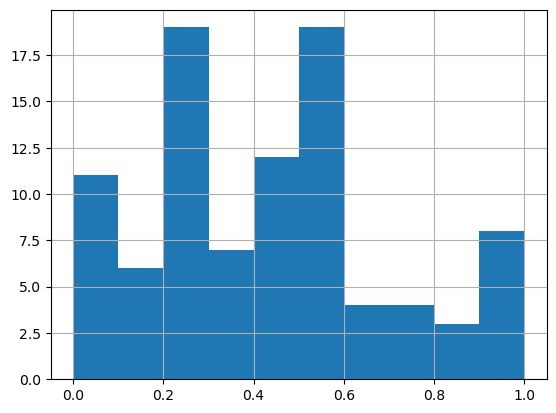

In [59]:
df_calc.recall.hist()

## Extend with hierarchy

In [61]:
# relative to Annif descriptors
ancestors_depth = 1
descendants_depth = 10

In [62]:
find_annif_descr_as_descendant_of_manual_descr_query_templ = '''
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX skosxl: <http://www.w3.org/2008/05/skos-xl#>

# Finding manual descriptor among the parents of Annif's descriptors

SELECT distinct ?paperURI ?annifDescrUri ?annifDescrLabelEN 
                          ("descendantOf" as ?relation)
                          ?manualDescrUri ?manualDescrLabelEN 
                          
FROM <http://agrovoc.fao.org/graph>

WHERE {
  
  VALUES (?paperURI) { (<%s>) }
  VALUES (?annifDescrUri) { %s }
  VALUES (?manualDescrUri) { %s }
  
  ?annifDescrUri skos:broader{1,%d} ?annifDescrParentUri.
  
  FILTER (?manualDescrUri = ?annifDescrParentUri)     
  
  ######################################################################
  # Find labels
  OPTIONAL {
    ?manualDescrUri skosxl:prefLabel/skosxl:literalForm ?manualDescrLabelEN;
                    skosxl:prefLabel/skosxl:literalForm ?manualDescrLabelFR.
    FILTER langMatches(lang(?manualDescrLabelEN), "en") 
    FILTER langMatches(lang(?manualDescrLabelFR), "fr") 
  }
  OPTIONAL  { 
    ?annifDescrUri  skosxl:prefLabel/skosxl:literalForm ?annifDescrLabelEN;
                    skosxl:prefLabel/skosxl:literalForm ?annifDescrLabelFR. 
    FILTER langMatches(lang(?annifDescrLabelEN), "en") 
    FILTER langMatches(lang(?annifDescrLabelFR), "fr") 
  }

}
'''

find_annif_descr_as_ancestors_of_manual_descr_query_templ = '''
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX skosxl: <http://www.w3.org/2008/05/skos-xl#>

# Finding manual descriptor among the parents of Annif's descriptors

SELECT distinct ?paperURI ?annifDescrUri ?annifDescrLabelEN
                          ("ancestorOf" as ?relation)
                          ?manualDescrUri ?manualDescrLabelEN 

FROM <http://agrovoc.fao.org/graph>

WHERE {
  
  VALUES (?paperURI) { (<%s>) }
  VALUES (?annifDescrUri) { %s }
  VALUES (?manualDescrUri) { %s }
  
  ?manualDescrUri skos:broader{1,%d} ?manualDescrParentUri.
  
  FILTER (?annifDescrUri = ?manualDescrParentUri)     
  
  ######################################################################
  # Find labels
  OPTIONAL {
    ?manualDescrUri skosxl:prefLabel/skosxl:literalForm ?manualDescrLabelEN;
                    skosxl:prefLabel/skosxl:literalForm ?manualDescrLabelFR.
    FILTER langMatches(lang(?manualDescrLabelEN), "en") 
    FILTER langMatches(lang(?manualDescrLabelFR), "fr") 
  }
  OPTIONAL  { 
    ?annifDescrUri  skosxl:prefLabel/skosxl:literalForm ?annifDescrLabelEN;
                    skosxl:prefLabel/skosxl:literalForm ?annifDescrLabelFR. 
    FILTER langMatches(lang(?annifDescrLabelEN), "en") 
    FILTER langMatches(lang(?annifDescrLabelFR), "fr") 
  }

}
'''

In [63]:
df_extend = {'ancestors': pd.DataFrame(),
             'descendants' : pd.DataFrame()}   

for paper in  df.paperURI.unique():
    
    unmatched_manual_descr = df.loc[(df.paperURI == paper) & df.rankHuman.notna()]# & df.rankAnnif.isna()]
    unmatched_annif_descr  = df.loc[(df.paperURI == paper) & df.rankHuman.isna()  & df.rankAnnif.notna()]
    
    manual_descr_values = ' '.join(['(<%s>)' % x for x in unmatched_manual_descr.descrUri])
    annif_descr_values = ' '.join(['(<%s>)' % x for x in unmatched_annif_descr.descrUri])
    
    # get ancestorsOf
    df_plus = sparql_service_to_dataframe(issa_agritrop_endpoint, 
                                         find_annif_descr_as_descendant_of_manual_descr_query_templ % (paper,
                                                                                                       annif_descr_values,
                                                                                                       manual_descr_values,
                                                                                                       descendants_depth  ) ) 
    
    df_extend['descendants'] = pd.concat([df_extend['descendants'], df_plus], ignore_index=True) 
    if (df_plus.shape[0] > 0):
        print(paper, df_plus.shape) 
    
    # get descedantsOf    
    df_plus = sparql_service_to_dataframe(issa_agritrop_endpoint, 
                                         find_annif_descr_as_ancestors_of_manual_descr_query_templ % (paper,
                                                                                                      annif_descr_values,
                                                                                                      manual_descr_values,
                                                                                                      ancestors_depth     ) ) 
    df_extend['ancestors'] = pd.concat([df_extend['ancestors'], df_plus], ignore_index=True ) 
    if (df_plus.shape[0] > 0):
        print(paper, df_plus.shape) 

print('ancestors :', df_extend['ancestors'].shape)
print('descendants :', df_extend['descendants'].shape)

http://data-issa.cirad.fr/document/576134 (1, 6)
http://data-issa.cirad.fr/document/577439 (3, 6)
http://data-issa.cirad.fr/document/577439 (1, 6)
http://data-issa.cirad.fr/document/577700 (1, 6)
http://data-issa.cirad.fr/document/577700 (3, 6)
http://data-issa.cirad.fr/document/578872 (2, 6)
http://data-issa.cirad.fr/document/580409 (2, 6)
http://data-issa.cirad.fr/document/580409 (1, 6)
http://data-issa.cirad.fr/document/580606 (2, 6)
http://data-issa.cirad.fr/document/580827 (1, 6)
http://data-issa.cirad.fr/document/580827 (1, 6)
http://data-issa.cirad.fr/document/581009 (3, 6)
http://data-issa.cirad.fr/document/581064 (1, 6)
http://data-issa.cirad.fr/document/581205 (1, 6)
http://data-issa.cirad.fr/document/581471 (2, 6)
http://data-issa.cirad.fr/document/581988 (2, 6)
http://data-issa.cirad.fr/document/582305 (2, 6)
http://data-issa.cirad.fr/document/582853 (1, 6)
http://data-issa.cirad.fr/document/583560 (1, 6)
http://data-issa.cirad.fr/document/583691 (1, 6)
http://data-issa.cir

In [68]:
#intersection  = pd.merge(df_extend['ancestors'], temp, how='inner',on=['paperURI', 'annifDescrUri'])
#union         = pd.merge(df_extend['ancestors'], temp, how='outer',on=['paperURI', 'annifDescrUri'])   
#union[union.isnull().any(axis=1)]

In [64]:
df_extend.pop('all', '')
df_extend['all'] = pd.concat(df_extend.values(), ignore_index=True)
    
print('all :', df_extend['all'].shape)

all : (91, 6)


In [65]:
# get the rank and conf values from original dataframe
df_extend['all'] = df_extend['all'].merge(df.loc[: , ['paperURI', 'descrUri', 'rankHuman']], 
                               left_on=['paperURI', 'manualDescrUri'],
                               right_on=['paperURI', 'descrUri'],
                               how='inner')

df_extend['all'] = df_extend['all'].merge(df.loc[: , ['paperURI', 'descrUri', 'rankAnnif', 'confAnnif']], 
                               left_on=['paperURI', 'annifDescrUri'],
                               right_on=['paperURI', 'descrUri'],
                               how='inner')

df_extend['all'].drop(columns=['descrUri_x', 'descrUri_y'], inplace=True)
df_extend['all'].rename(columns={"rankHuman": "rankHumanR"}, inplace=True)

In [66]:
df_extend['all'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91 entries, 0 to 90
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   paperURI            91 non-null     object 
 1   annifDescrUri       91 non-null     object 
 2   annifDescrLabelEN   91 non-null     object 
 3   relation            91 non-null     object 
 4   manualDescrUri      91 non-null     object 
 5   manualDescrLabelEN  91 non-null     object 
 6   rankHumanR          91 non-null     float64
 7   rankAnnif           91 non-null     float64
 8   confAnnif           91 non-null     float64
dtypes: float64(3), object(6)
memory usage: 7.1+ KB


In [67]:
# merge extended matches with original

df_ext = df.merge(df_extend['all'].loc[:, ['paperURI', 'annifDescrUri', 'relation', 'manualDescrLabelEN', 'rankHumanR']],
                           right_on=['paperURI', 'annifDescrUri'],
                           left_on=['paperURI', 'descrUri'],
                       how='left')

df_ext.drop(columns=['annifDescrUri'], inplace=True)
df_ext['rankHumanExt'] = df_ext.rankHuman.combine_first(df_ext.rankHumanR)


## Save results

In [68]:
df_ext.head()

,lang,paperURI,agritrop_url,paperID,descrUri,descrLabelEN,descrLabelFR,rankHuman,rankAnnif,confAnnif,relation,manualDescrLabelEN,rankHumanR,rankHumanExt
0,eng,http://data-issa.cirad.fr/document/576134,http://agritrop.cirad.fr/576134/,576134,http://aims.fao.org/aos/agrovoc/c_2018,cultivation,pratique culturale,1.00,NaN,NaN,NaN,NaN,NaN,1.00
1,eng,http://data-issa.cirad.fr/document/576134,http://agritrop.cirad.fr/576134/,576134,http://aims.fao.org/aos/agrovoc/c_1374567058134,climate change adaptation,adaptation aux changements climatiques,2.00,2.00,0.48,NaN,NaN,NaN,2.00
2,eng,http://data-issa.cirad.fr/document/576134,http://agritrop.cirad.fr/576134/,576134,http://aims.fao.org/aos/agrovoc/c_7113,small farms,petite exploitation agricole,3.00,NaN,NaN,NaN,NaN,NaN,3.00
3,eng,http://data-issa.cirad.fr/document/576134,http://agritrop.cirad.fr/576134/,576134,http://aims.fao.org/aos/agrovoc/c_1666,climate change,changement climatique,4.00,1.00,0.67,NaN,NaN,NaN,4.00
4,eng,http://data-issa.cirad.fr/document/576134,http://agritrop.cirad.fr/576134/,576134,http://aims.fao.org/aos/agrovoc/c_2228,development policies,politique de développement,5.00,11.00,0.18,NaN,NaN,NaN,5.00


In [69]:
df_ext.to_csv('sample of indexed articles.no body text.with hierarchy.2.0.csv' , encoding='utf-8',
          index=False, float_format='%.2f')

In [70]:
df_adapted = copy.deepcopy(df_ext)
df_adapted.insert(2, 'Visualisation enrichie', df_adapted.paperURI.apply(lambda x: 'http://erebe-vm3.i3s.unice.fr/visu/?uri=%s' % x) )

df_adapted['Manual'] = df_adapted.apply(lambda r: '' if math.isnan(r.rankHumanExt) else ('x' if math.isnan(r.rankHumanR) else '*' ) , axis=1)
df_adapted['Annif']  = df_adapted.rankAnnif.apply(lambda x: '' if math.isnan(x) else 'x')

df_adapted.drop(columns=['paperURI', 'rankHuman', 'rankAnnif', 'confAnnif', 'rankHumanR', 'rankHumanExt'], inplace=True)
df_adapted.head()

,lang,Visualisation enrichie,agritrop_url,paperID,descrUri,descrLabelEN,descrLabelFR,relation,manualDescrLabelEN,Manual,Annif
0,eng,http://erebe-vm3.i3s.unice.fr/visu/?uri=http://data-issa.cirad.fr/document/5...,http://agritrop.cirad.fr/576134/,576134,http://aims.fao.org/aos/agrovoc/c_2018,cultivation,pratique culturale,NaN,NaN,x,
1,eng,http://erebe-vm3.i3s.unice.fr/visu/?uri=http://data-issa.cirad.fr/document/5...,http://agritrop.cirad.fr/576134/,576134,http://aims.fao.org/aos/agrovoc/c_1374567058134,climate change adaptation,adaptation aux changements climatiques,NaN,NaN,x,x
2,eng,http://erebe-vm3.i3s.unice.fr/visu/?uri=http://data-issa.cirad.fr/document/5...,http://agritrop.cirad.fr/576134/,576134,http://aims.fao.org/aos/agrovoc/c_7113,small farms,petite exploitation agricole,NaN,NaN,x,
3,eng,http://erebe-vm3.i3s.unice.fr/visu/?uri=http://data-issa.cirad.fr/document/5...,http://agritrop.cirad.fr/576134/,576134,http://aims.fao.org/aos/agrovoc/c_1666,climate change,changement climatique,NaN,NaN,x,x
4,eng,http://erebe-vm3.i3s.unice.fr/visu/?uri=http://data-issa.cirad.fr/document/5...,http://agritrop.cirad.fr/576134/,576134,http://aims.fao.org/aos/agrovoc/c_2228,development policies,politique de développement,NaN,NaN,x,x


In [71]:
df_adapted.to_csv('sample of indexed articles.no body text.with hierarchy.adapted.2.0.csv' , encoding='utf-8', index=False)
del df_adapted

## Recalculate metrics

In [72]:
df_calc = df_ext.drop_duplicates(subset=['paperID', 'descrUri'])\
                .groupby(by='paperID').agg({
                                            'lang' : (lambda x: list(x)[0] ),
                                            'rankHuman': _one_hot,
                                            'rankHumanExt': _one_hot,
                                            'rankAnnif': _one_hot,
                                            'descrLabelEN' : list})

df_calc['JaccardIndex'] = df_calc.apply( lambda x: metrics.jaccard_score(x.rankHuman, x.rankAnnif), axis=1 )
df_calc['JaccardIndex_ext'] = df_calc.apply( lambda x: metrics.jaccard_score(x.rankHumanExt, x.rankAnnif), axis=1 )

df_calc['F1'] = df_calc.apply( lambda x: metrics.f1_score(x.rankHuman, x.rankAnnif), axis=1 )
df_calc['F1_ext'] = df_calc.apply( lambda x: metrics.f1_score(x.rankHumanExt, x.rankAnnif), axis=1 )

df_calc['Recall'] = df_calc.apply( lambda x: metrics.recall_score(x.rankHuman, x.rankAnnif), axis=1 )
df_calc['Recall_ext'] = df_calc.apply( lambda x: metrics.recall_score(x.rankHumanExt, x.rankAnnif), axis=1 )

df_calc['Precision'] = df_calc.apply( lambda x: metrics.precision_score(x.rankHuman, x.rankAnnif), axis=1 )
df_calc['Precision_ext'] = df_calc.apply( lambda x: metrics.precision_score(x.rankHumanExt, x.rankAnnif), axis=1 )

# precision_score. recall_score

df_calc.shape

(93, 13)

In [73]:
df_calc.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
JaccardIndex,93.00,0.24,0.15,0.00,0.14,0.24,0.33,0.67
JaccardIndex_ext,93.00,0.30,0.17,0.00,0.17,0.30,0.41,0.67
F1,93.00,0.37,0.19,0.00,0.25,0.38,0.50,0.80
F1_ext,93.00,0.43,0.22,0.00,0.29,0.46,0.58,0.80
Recall,93.00,0.43,0.27,0.00,0.25,0.43,0.58,1.00
Recall_ext,93.00,0.47,0.28,0.00,0.29,0.50,0.65,1.00
Precision,93.00,0.39,0.22,0.00,0.25,0.38,0.50,1.00
Precision_ext,93.00,0.49,0.27,0.00,0.30,0.50,0.67,1.00


Save

In [74]:
df_calc.drop(columns=['rankHuman', 'rankHumanExt', 'rankAnnif','descrLabelEN'])\
    .sort_values(by=['lang', 'paperID'])\
    .to_csv('metrics for sample of indexed articles.no body text.with hierarchy.2.0.csv' , encoding='utf-8',
          index=True, float_format='%.2f')

Visualize

In [75]:
def summary_dataframe(df_metrics, col_prefix='', col_suffix='', from_id=0, title=''):
    df_summary = pd.DataFrame(columns=['language', 'Recall', 'Precision', 'F1 score', 'Jaccard Index'])

    df_summary['language'] = df_metrics.keys() #pd.Series(['en', 'fr', 'both'])
    df_summary.set_index('language', inplace=True)
    df_summary.columns.name = title
    
    #sr_count = pd.Series(data=[0,0,0], index=['en', 'fr', 'both'], dtype='int')
    sr_count = pd.Series(data=[0] * len(df_metrics), index=df_metrics.keys(), dtype='int')
    
    df_metrics_view = df_metrics.copy()
    #df_metrics_view['both'] = pd.concat(df_metrics_view.values() )

    for lang, df in df_metrics_view.items():
        df = df.loc[df.paperID > from_id,]
        sr_count[lang] = df.shape[0]
        df_summary.loc[lang , 'F1 score'] = df.F1.mean()
        df_summary.loc[lang , 'Recall'] = df.Recall.mean()
        df_summary.loc[lang , 'Precision'] = df.Precision.mean()
        df_summary.loc[lang , 'Jaccard Index'] = df.JaccardIndex.mean()


    df_summary.rename(columns= dict(zip(df_summary.columns, [ col_prefix  + 'avg. '+  c + col_suffix for c in df_summary.columns])),
                            inplace=True)
    
    df_summary.insert(0, 'Docs', sr_count)
                                
    return df_summary 


In [86]:
df_calc.reset_index(inplace=True)

df_metrics = {'en' : df_calc.loc[df_calc.lang == 'eng'],
              'fr' : df_calc.loc[df_calc.lang == 'fre'],
              'both' : df_calc}

col_h = ['paperID', 'lang'] + [col for col in df_calc.columns if '_ext' in col]

renaming = {col: col.split('_')[0] for col in df_calc.columns if '_ext' in col}

df_metrics_h = {'en' : df_calc.loc[df_calc.lang == 'eng', col_h].rename(columns=renaming) ,
                'fr' : df_calc.loc[df_calc.lang == 'fre', col_h].rename(columns=renaming),
                'both' : df_calc.loc[:, col_h].rename(columns=renaming)}

summary_dataframe(df_metrics_h)
table_style = [{"selector": "", "props": [("border", "3px solid yellow !important")]},
               {"selector": "td", "props": [("border", "1px solid grey !important")]},
               {"selector": "th", "props": [("border", "1px solid grey !important")]}  ]

pd.concat([summary_dataframe(df_metrics).transpose(), summary_dataframe(df_metrics_h).transpose()], axis=0) \
     .sort_index() \
     .set_index(pd.MultiIndex.from_product([summary_dataframe(df_metrics).columns.sort_values(), ['', '+hierarchy',]])) \
          .round(2) \
     .transpose() \
     .style.set_table_styles(table_style) \
     .format(precision=2) \
     .set_caption('Metriccs for the sample set') \
     .highlight_max(subset='avg. F1 score', color='lightyellow', axis=1) \
     .highlight_max(subset='avg. Jaccard Index', color='lightyellow', axis=1) \
     .highlight_max(subset='avg. Precision', color='lightyellow', axis=1) \
     .highlight_max(subset='avg. Recall', color='lightyellow', axis=1)

## Calculate metrics in SPARQL

In [88]:
quality_metrics_short_query_template = '''
PREFIX dce: <http://purl.org/dc/elements/1.1/>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX prov: <http://www.w3.org/ns/prov#>
prefix bibo:   <http://purl.org/ontology/bibo/>
PREFIX dct:    <http://purl.org/dc/terms/>
PREFIX fabio:  <http://purl.org/spar/fabio/>
PREFIX oa:     <http://www.w3.org/ns/oa#>
PREFIX rdfs:   <http://www.w3.org/2000/01/rdf-schema#>
PREFIX issa:   <http://data-issa.cirad.fr/>
PREFIX issapr:   <http://data-issa.cirad.fr/property/>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX skosxl: <http://www.w3.org/2008/05/skos-xl#>

SELECT  ?lang
        (?paper AS ?paperURI) ?paperID 
        ?TP ?FN ?FP ?UNION
        (?TP / (xsd:float( ?TP + ?FN) + 0.000001)  as ?Recall)
        (?TP / (xsd:float( ?TP + ?FP) + 0.000001)  as ?Precision)
        ( 2 * ?Precision * ?Recall / (?Precision + ?Recall + 0.000001) as ?F1)
        ( ?TP / xsd:float(?UNION) as ?JaccardIndex)

FROM <http://data-issa.cirad.fr/graph/documents>
FROM <http://data-issa.cirad.fr/graph/thematic-descriptors>
FROM <http://data-issa.cirad.fr/graph/annif-descriptors>
FROM <http://agrovoc.fao.org/graph>

WHERE {
  SELECT  ?paper ?paperID
          (sum(?tp) as ?TP)
          (sum(?fn) as ?FN)
          (sum(?fp) as ?FP)
          (count (distinct ?descrUri) as ?UNION)
          (SAMPLE(?lang) AS ?lang)

  WHERE { 
    # need this encapsulating select to eliminate the same parents 
    
    SELECT  ?paper ?paperID ?descrUri 
            (MAX(?tp) as ?tp) 
            (MIN(?fp) AS ?fp) 
            (MIN(?fn) as ?fn) 
            (SAMPLE(?lang) AS ?lang)
 
    WHERE {
      VALUES (?paper) { %s }
      #VALUES (?paper) { (<http://data-issa.cirad.fr/document/600248>) }
      
      ?paper dct:identifier ?paperID;
             dce:language ?lang.
             #FILTER (%s EXISTS { ?paper a bibo:AcademicArticle } )
      {
        # Match manual descriptors to automatic descriptors
        ?descrHuman a issa:ThematicDescriptorAnnotation;
                    oa:hasBody ?descrUri;
                    oa:hasTarget ?paper;
                    issapr:rank  ?rankHuman;
                    prov:wasAttributedTo issa:AgritropDocumentalist.  
        optional {
          ?descrAnnif a issa:ThematicDescriptorAnnotation;
                      oa:hasBody ?descrUri;
                      oa:hasTarget ?paper;
                      issapr:rank  ?rankAnnif;
                      issapr:confidence  ?confAnnif;
                      prov:wasAttributedTo issa:AnnifSubjectIndexer. }
    }
    UNION
    {
    	# Match automatic descriptors with children (descendants) or patents(descendants) of manual descriptors 
        ?descrAnnif a issa:ThematicDescriptorAnnotation;
                    oa:hasBody?descrUri;
                    oa:hasTarget ?paper;
                    issapr:rank  ?rankAnnif;
                    issapr:confidence  ?confAnnif;
                    prov:wasAttributedTo issa:AnnifSubjectIndexer.

        optional {
          ?descrHuman a issa:ThematicDescriptorAnnotation;
                      # {0, 0} = match
                      # {0, 1} = immediate child/parent
                      # {0, 10} = 10 levels of hierarchy up ior down 
                      # narrower does not work, use ^boroader
                      oa:hasBody | oa:hasBody/skos:broader{0,%d} | oa:hasBody/^skos:broader{0,%d} ?descrUri; #narrower does not work
                      oa:hasBody ?descrUriOrig;
                      oa:hasTarget ?paper;
                      issapr:rank  ?rankHuman;
                      prov:wasAttributedTo issa:AgritropDocumentalist  }
          
      }

    bind (IF( BOUND(?descrHuman) &&  BOUND(?descrAnnif), 1, 0 ) as ?tp)
    bind (IF( BOUND(?descrHuman) &&  !BOUND(?descrAnnif), 1, 0 ) as ?fn)
    bind (IF( !BOUND(?descrHuman) &&  BOUND(?descrAnnif), 1, 0 ) as ?fp)
    
    FILTER (COALESCE(?rankAnnif , 0) < %d  )  
    FILTER (COALESCE(?confAnnif, 1.0) > %f )  
  
 }
 group by ?paper ?paperID ?descrUri ?descrLabel 
}
group by ?paper ?paperID
# select only the papers that have at least some number of uman descriptors
having ((sum(?tp) + sum(?fn)) > %d   ) 
}
order by ?paperID
'''

In [89]:
def query_metrics(paper_list, articles_only=True, 
                              ancestors_depth=0,   # (1)
                              descendants_depth=0, # (10)
                              topK_annif=15,
                              min_conf= 0.1,
                              min_manual = 1):

    values = ' '.join(['(<%s>)' % x for x in paper_list])
    subset = ' ' if articles_only else 'NOT'
    
    query = quality_metrics_short_query_template % (values ,
                                                  subset,
                                                  ancestors_depth, 
                                                  descendants_depth, 
                                                  topK_annif + 1, min_conf,
                                                  min_manual - 1 )
    
    #print(query)
   
    df= sparql_service_to_dataframe(issa_agritrop_endpoint, query, remove_comments=True)

    df= df.astype({'paperID': 'int',
                    'TP': 'float',
                    'FN': 'float',
                    'FP': 'float',
                    'Recall': 'float',
                    'Precision': 'float',
                    'F1': 'float',
                    'JaccardIndex': 'float' })
    print(df.shape)

    return df

In [90]:
ancestors_depth  = 1
descendants_depth = 10

topK_annif = 15
min_manual = 3

min_conf = 0.1

In [91]:
random_paper_ids['en']

,paperURI,paperID,lang
0,http://data-issa.cirad.fr/document/576134,576134,eng
1,http://data-issa.cirad.fr/document/576338,576338,eng
2,http://data-issa.cirad.fr/document/577439,577439,eng
4,http://data-issa.cirad.fr/document/577700,577700,eng
6,http://data-issa.cirad.fr/document/578872,578872,eng
...,...,...,...
87,http://data-issa.cirad.fr/document/601277,601277,eng
88,http://data-issa.cirad.fr/document/602216,602216,eng
89,http://data-issa.cirad.fr/document/603115,603115,eng
91,http://data-issa.cirad.fr/document/603314,603314,eng


In [92]:
# exact match
metrics_df = {'en' : query_metrics(random_paper_ids['en'].paperURI, min_manual=min_manual),
              'fr' : query_metrics(random_paper_ids['fr'].paperURI, min_manual=min_manual) }

metrics_df['both'] = pd.concat(metrics_df.values())
              
metrics_df['both'].shape

(0, 11)
(0, 11)


(0, 11)

In [80]:
# match with hiererarchy
metrics_df_h = {'en' : query_metrics(random_paper_ids['en'].paperURI, ancestors_depth=1, descendants_depth=10, 
                                                                      min_manual=min_manual),
                'fr' : query_metrics(random_paper_ids['fr'].paperURI, ancestors_depth=1, descendants_depth=10,
                                                                      min_manual=min_manual) }

metrics_df_h['both'] = pd.concat(metrics_df_h.values())
              
metrics_df_h['both'].shape

(0, 11)
(0, 11)


(0, 11)

In [81]:
metrics_df['both'].sort_values(by=['paperID']).head()

,lang,paperURI,paperID,TP,FN,FP,UNION,Recall,Precision,F1,JaccardIndex


In [83]:
# Verify against sklearn
pd.merge(metrics_df['both'].loc[:, ['paperID', 'TP', 'UNION', 'Recall']], 
         metrics_df['both'].loc[:, ['paperID', 'Recall']] ,
         on = 'paperID', how='inner').sort_values('paperID')

,TP,UNION,Recall_x,paperID,Recall_y


In [152]:
table_style = [{"selector": "", "props": [("border", "3px solid yellow !important")]},
               {"selector": "td", "props": [("border", "1px solid grey !important")]},
               {"selector": "th", "props": [("border", "1px solid grey !important")]}  ]

pd.concat([summary_dataframe(metrics_df).transpose(), summary_dataframe(metrics_df_h).transpose()], axis=0) \
     .sort_index() \
     .set_index(pd.MultiIndex.from_product([summary_dataframe(df_metrics).columns.sort_values(), ['', '+hierarchy',]])) \
          .round(2) \
     .transpose() \
     .style.set_table_styles(table_style) \
     .format(precision=2) \
     .set_caption('Metriccs for the sample set') \
     .highlight_max(subset='avg. F1 score', color='lightyellow', axis=1) \
     .highlight_max(subset='avg. Jaccard Index', color='lightyellow', axis=1) \
     .highlight_max(subset='avg. Precision', color='lightyellow', axis=1) \
     .highlight_max(subset='avg. Recall', color='lightyellow', axis=1)